In [1]:
import os
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
#plt.rcParams.update({"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": ["Helvetica"]})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from astropy import units as u
from gatspy.periodic import LombScargleFast
from astroquery.jplhorizons import Horizons

In [2]:
#####-----CONSTANTS/stuff to check-----#####

beta = 0.059   # standard value of phase slope by which to correct apparent mags
real_period = 12.4041/24. # hours
phase_to_real_period = False
limiting_rh = 3.5  # Value of rh beyond which to accept data points (minimise possibility of activity)
obj = '90000695'

In [3]:
# read in lightcurve data
home_path = os.path.expanduser('~/')
data_dir = home_path+'Documents/year1/shape_modelling/67p/'
file = data_dir+'67P_LCs_ALL_R.dat'

data = pd.read_table(file, sep=' ')
data_table = data.to_numpy()

col_names = []
for col in data:
    col_names.append(col)
print('Column names for table:')
print(', '.join(col_names))

Column names for table:
mjd, mag, m_app, rh, delta, alpha, unc


In [4]:
# Rename necessary columns to their respective column names:
mjd = data_table[:,0]
app_mag = data_table[:,2]
rh = data_table[:,3]
delta = data_table[:,4]
alpha = data_table[:,5]
unc = data_table[:,-1]

In [5]:
# Now treating the lightcurve points as if they are real, apparent magnitudes obtained observationally
# Will correct for distance and for standard phase function with slope beta=0.045

# Absolute magnitude correction:

def convertToH0(m,b,a,r,d):
    H_r = m - (b*a) - (5.0*np.log10(r*d))
    return H_r

In [6]:
# Generate list of absolutely corrected magnitudes:
# Account here for minimum distance to the sun
magsPeriod = []; mjdPeriod = []; uncPeriod = []; rhPeriod=[]

for i in range(len(app_mag)):
    if (rh[i]>=limiting_rh):
        magsPeriod.append(convertToH0(app_mag[i], beta, alpha[i], rh[i], delta[i]))
        mjdPeriod.append(mjd[i])
        uncPeriod.append(unc[i])
        rhPeriod.append(rh[i])
magsPeriod=np.array(magsPeriod)
npoints = len(magsPeriod)
print('No. values at heliocentric distance >%.1fau is %i out of possible %i'%(limiting_rh, npoints, len(app_mag)))
# Rescale points in mjdPeriod to=0
mjdPeriod = np.array(mjdPeriod)#-mjdPeriod[0]

No. values at heliocentric distance >3.5au is 567 out of possible 678


In [7]:
t_days = np.array(mjdPeriod)#*u.day
mags = magsPeriod#*u.mag
mags_unc = uncPeriod#*u.mag

In [8]:
# Import perihelion time for 67P
peri_mjd = []
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[0])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
per = float(els['P'])
print(peri_mjd, per/365.)

[2459519.123068307] 6.469691483002241


In [9]:
# Find next point one orbital period along to draw lines on the plot

mjd_newepoch = mjdPeriod[0]+per

for i in range(len(mjdPeriod)):
    if mjdPeriod[i]>=mjd_newepoch:
        index_newepoch = i
        break

In [10]:
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[index_newepoch])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
print(peri_mjd)

[2459519.123068307, 2461872.266094989]


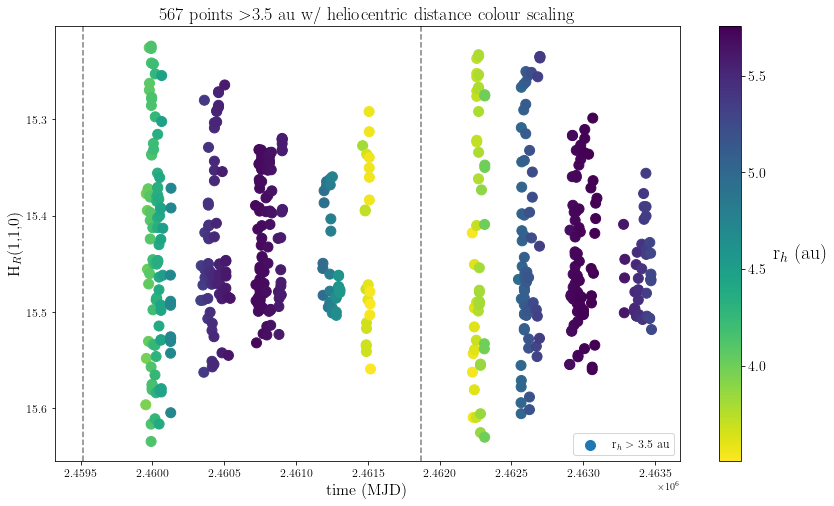

In [11]:
# Have a look at data
labels=16; ticks=12; titles=18
plt.figure(figsize=(14,8))
for apparition in peri_mjd:
    v = plt.axvline(apparition, linestyle='--', color='grey')
plt.scatter(mjdPeriod, magsPeriod, c=rhPeriod, cmap='viridis_r', s=100, label='r$_h >$ %.1f au'%(limiting_rh))
#plt.errorbar(mjdPeriod, magsPeriod, yerr=uncPeriod, fmt='.',ecolor='rhPeriod')
plt.xlabel('time (MJD)', fontsize=labels)
plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.gca().invert_yaxis()

# Set colourbar to be actually readable and useful
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label(r' r$_h$ (au)', rotation=0,  labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_yticklabels(['3.6', '4.0', '4.5', '5.0', '5.5'])
plt.title(r"%s points \textgreater %.1f au w/ heliocentric distance colour scaling"%(str(npoints), limiting_rh), fontsize=titles)
plt.legend(loc=4, fontsize=ticks)
plt.show()
#plt.savefig(datadir+'paper_pics/'+'')
#fig, ax = plt.subplots(figsize=(16, 6))
#ax.errorbar(mjdPeriod, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0)
#ax.set(xlabel='time (MJD)', ylabel='magnitude', title='67P LSST magnitudes')
#ax.invert_yaxis()

In [12]:
# Choosing Nyquist sampling frequency:
# Just out of curiosity, doesn't really work with uneven sampling
tdiff = []

for i,time in enumerate(t_days[1:-1]):
    tdiff.append(abs(time-t_days[i]))
print(1./(2.*np.mean(tdiff)), 1./(2.*np.median(tdiff)), 1./(2.*max(tdiff)), 1./(2.*min(tdiff)))

0.08030923192277065 12.557450395851275 0.0007053832546208402 1308.901725873969


In [13]:
# Trialling different periodogram methods:
#  i) gatspy LombScargleFast
# ii) Astropy

In [14]:
# period range to sample:

min_prot=0.1#*u.day # days
max_prot=2.#*u.day # days
Nsample = 100000
# Define frequency range:
freq = np.linspace(1./max_prot, 1./min_prot, Nsample)

In [15]:
# i)

model_gp = LombScargleFast().fit(t_days, mags, mags_unc)
model_gp.optimizer.set(period_range=(min_prot,max_prot))
best_period_gp = model_gp.best_period
print("Best period (gatspy) = {0:.6f}h".format((best_period_gp)*24.))

periods_gp = np.linspace(min_prot, max_prot, Nsample)
power_gp = model_gp.periodogram(periods_gp)

Finding optimal frequency:
 - Estimated peak width = 0.00178
 - Using 5 steps per peak; omega_step = 0.000357
 - User-specified period range:  0.1 to 2
 - Computing periods at 167278 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Best period (gatspy) = 6.202740h


/Users/s1523386/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


In [16]:
#index_max_gp = np.where(power_gp==max(power_gp))
print(periods_gp[np.argmax(power_gp)]*24.)

12.873968739687397


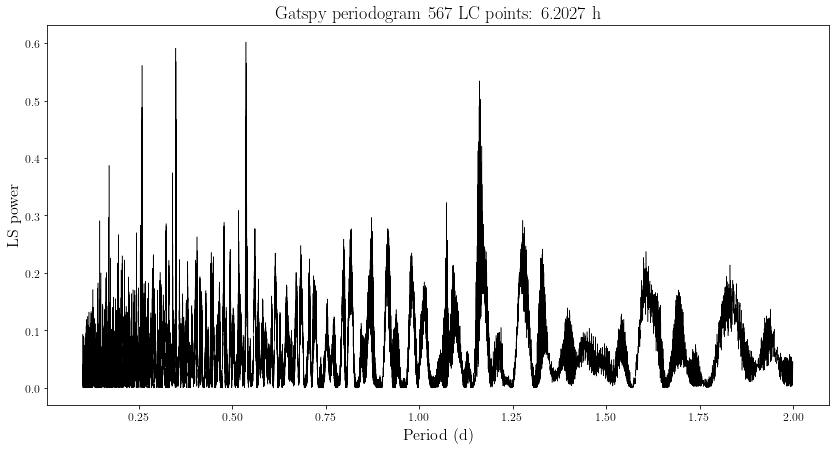

In [17]:
plt.figure(figsize=(14,7))
plt.plot(periods_gp, power_gp,color='k',linewidth=0.5)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.xlabel('Period (d)', fontsize=labels)
plt.ylabel('LS power', fontsize=labels)
plt.title('Gatspy periodogram %i LC points: %.4f h'%(npoints, best_period_gp*24.), fontsize=titles)
plt.show()

In [18]:
# Phase the data to the best period
multiplier = 2.

if phase_to_real_period==True:
    final_period_gp = real_period
    phase_gp = t_days/final_period_gp % 1
    print('Using real period %.4f'%(real_period*24.))
else:
    final_period_gp = multiplier*best_period_gp
    phase_gp = t_days/final_period_gp % 1
    print('Phase to %.1fx best-fit LS (gatspy) period %.4f h'%(multiplier, best_period_gp*24.))

Phase to 2.0x best-fit LS (gatspy) period 6.2027 h


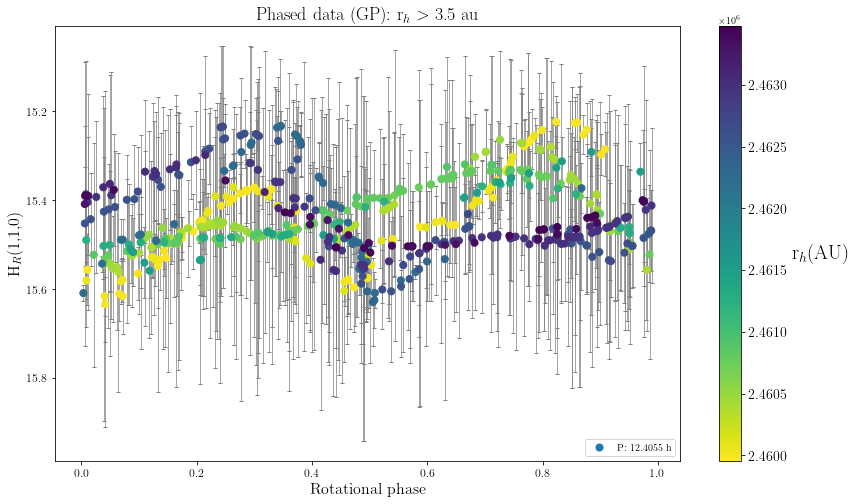

In [27]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_gp, power_gp)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power', title='Lomb-Scargle Periodogram')

#ax[1].errorbar(phase_gp, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(real_period*24.))#multiplier*24.*best_period_gp))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_gp, magsPeriod, c=mjdPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_gp), zorder=2)
plt.errorbar(phase_gp, magsPeriod, yerr=mags_unc, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Rotational phase', fontsize=labels);plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label('r$_h$(AU)', rotation=0, labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
plt.title('Phased data (GP): r$_h >$ %.1f au'%limiting_rh, fontsize=titles)
plt.gca().invert_yaxis()
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
#plt.show()
plt.savefig(data_dir+'paper_pics/'+'phased_lc_rh_%s_gp_P_%.4f_colorMJD.png'%(str(limiting_rh), 24.*final_period_gp), format='png', dpi=200)



In [20]:
weird_points = []
for i,val in enumerate(magsPeriod):
    if val>15.77 and 0.45<phase_gp[i]<0.7:
        print(val, phase_gp[i], mjdPeriod[i],i)
        weird_points.append(mjdPeriod[i])
#max(weird_points)-min(weird_points)

In [21]:
# ii): 
# Astropy periodogram implementation:
power_ap = LombScargle(t_days, mags, mags_unc).power(freq, method='fast')

best_frequency_ap = freq[np.argmax(power_ap)]
best_period_ap = 1./best_frequency_ap
print("Best period (astropy) = {0:.6f}h".format((best_period_ap)*24.))
periods_ap = 1./freq

Best period (astropy) = 6.202666h


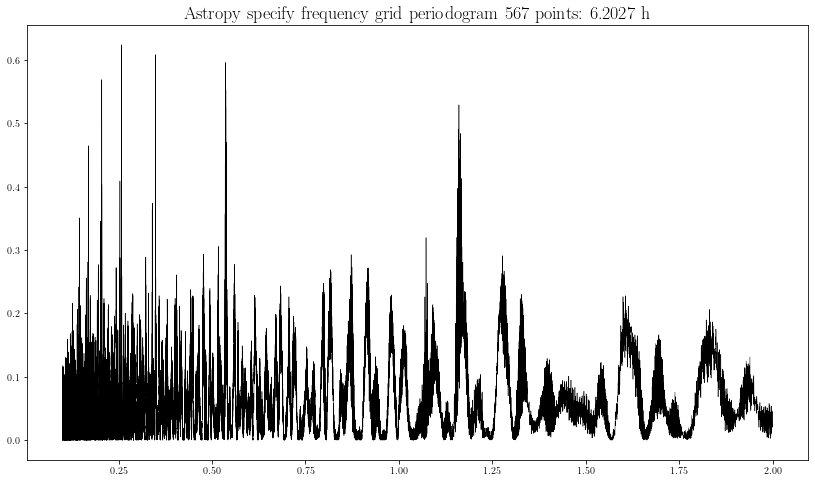

In [22]:
plt.figure(figsize=(14,8))
plt.plot(periods_ap, power_ap,color='k',linewidth=0.5)
plt.title('Astropy specify frequency grid periodogram %i points: %.4f h'%(npoints, (best_period_ap)*24.),fontsize=titles)

plt.show()

In [23]:
if phase_to_real_period==True:
    final_period_ap = real_period
    phase_ap = t_days/final_period_ap % 1
    print('Using real period %.4f'%(final_period_ap*24.))
else:
    final_period_ap = multiplier*best_period_ap
    phase_ap = t_days/final_period_ap % 1
    print('Phase to %.1fx best-fit LS (astropy) period %.4fh'%(multiplier, best_period_ap*24.))

Phase to 2.0x best-fit LS (astropy) period 6.2027h


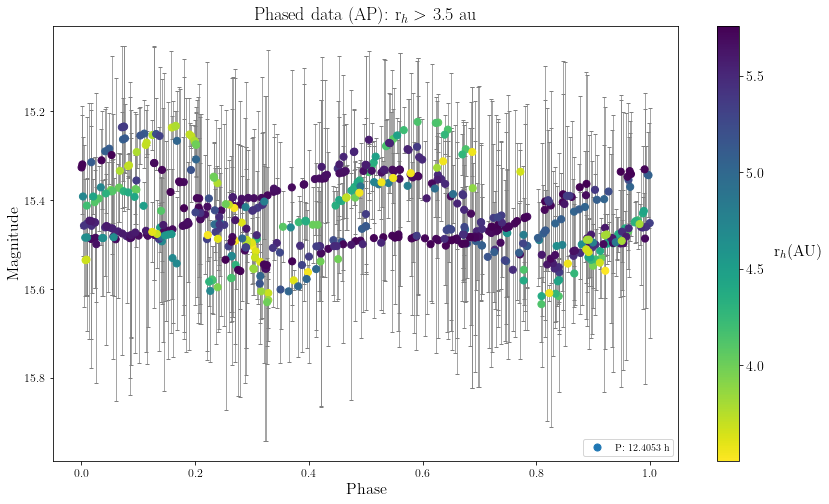

In [24]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_ap, power_ap)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power (AP)', title='Lomb-Scargle Periodogram (AP)')

#ax[1].errorbar(phase_ap, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(multiplier*24.*best_period_ap))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data (AP)')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_ap, magsPeriod, c=rhPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_ap), zorder=2)
plt.errorbar(phase_ap, magsPeriod, yerr=mags_unc, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Phase', fontsize=labels);plt.ylabel('Magnitude', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label('r$_h$(AU)', labelpad=35, rotation=0, fontsize=labels)
cbar.ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()
plt.title('Phased data (AP): r$_h >$ %.1f au'%limiting_rh, fontsize=titles)
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
plt.show()